In [1]:
from __future__ import print_function, division
# import mdtraj as md
# from mdtraj.utils import ensure_type
# from mdtraj.geometry import compute_distances, compute_angles
# from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
# from mdtraj.geometry import _geometry
# from mdtraj.utils import ensure_type
# from mdtraj.geometry import compute_distances, compute_angles
from itertools import groupby
#from matplotlib import
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
print(torch.__version__)
import torchmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


2.2.2


In [2]:
dmat = np.load("distance_matrix_full_LIG.npy")

In [3]:
def combined_residence_events(data):
  idx = np.arange(len(data[:,0]))
  
  bool = np.where(data<.6,1,0)
  any_event_residue = np.any(bool, axis=1)
  
  comp = np.stack([idx,any_event_residue],axis = 1)
  return [i[:,0][1:] if len(i)>1 else i[:,0] for i in filter(lambda x:any(x[:,1]!=0),np.split(comp,np.where(comp[:,1]==0)[0]))]

In [4]:
print(dmat.shape)
# events_all = combined_residence_events(dmat)
# event = events_all[0]
# test = np.mean(dmat[event[0]:event[-1]+1], axis=0)

# print(test.shape)

(1100889, 20)


In [5]:

events_all = combined_residence_events(dmat)
mapping = np.zeros(len(events_all))
avg = np.zeros([len(events_all), len(dmat[0,:])])
print(avg.shape)
print(len(events_all))
print(len(mapping))


count = 0
for event in events_all:
  mapping[count] = len(event)
  avg[count] = np.mean(dmat[event[0]:event[-1]+1], axis=0)
  count += 1
  
print(avg[-1])

    

(32264, 20)
32264
32264
[1.57703245 1.53463316 1.4436698  1.57972646 1.42884362 1.35897529
 1.28370154 1.25573933 1.12461925 1.17081571 0.9950667  1.131145
 0.77652729 0.68477958 0.50682896 0.35739088 0.41354325 0.44983658
 0.57703733 0.71103626]


[12021  7432  5990  4327  3629  3253  2877  2839  2397  2233  2032  2003
  1990  1840  1805  1700  1621  1620  1603  1580]


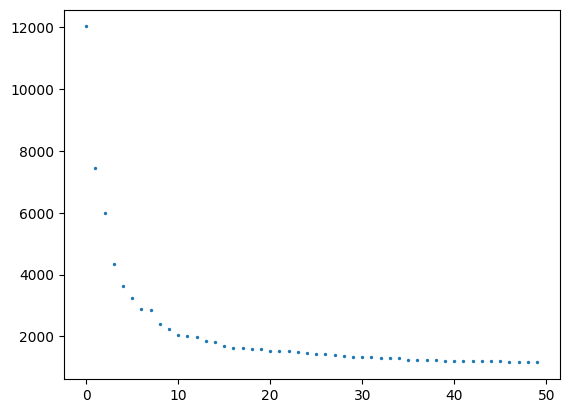

In [6]:
plotevents = np.sort(np.array([len(i) for i in events_all]))[::-1]
ploteventsintime = np.array([len(i) for i in events_all])

plt.scatter(np.arange(50), plotevents[:50], s = 2)
print(plotevents[:20])

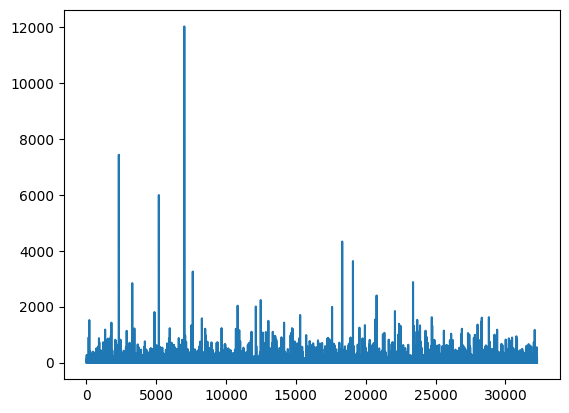

In [7]:
plt.plot(ploteventsintime)

In [8]:
# std = np.std(mapping)
# mean = np.mean(mapping)
# print(std, mean)
# mapping = (mapping - mean)/std
print(mapping)

print(np.max(mapping))
print(np.min(mapping))
logmapping = np.log(mapping)
print(logmapping)

[ 96.   1.   3. ...  17.   1. 158.]
12021.0
1.0
[4.56434819 0.         1.09861229 ... 2.83321334 0.         5.06259503]


In [9]:
inputs = torch.from_numpy(avg)
inputs = torch.tensor(inputs, dtype=torch.float32)
print(inputs.shape)
print(inputs)
targets= torch.from_numpy(np.reshape(logmapping, (logmapping.shape[0],1)))
targets = torch.tensor(targets, dtype=torch.float32)
# targets = targets.type(torch.LongTensor)
print(targets.shape)
print(targets)
dataset = TensorDataset(inputs, targets)


N = len(dataset)
indices = np.arange(N)
indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.85*N)]
test_indices = indices[int(0.85*N):int(1*N)]

print(len(train_indices))
print(train_indices)
train_len = len(train_indices)
print(len(val_indices))
print(val_indices)
val_len = len(val_indices)
print(len(test_indices))
print(test_indices)
test_len = len(test_indices)

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

batch_size = 64
train_dataloader = DataLoader(train_set, batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size)
test_dataloader = DataLoader(test_set, batch_size)

torch.Size([32264, 20])
tensor([[1.0387, 0.9685, 0.7676,  ..., 1.7369, 1.6272, 1.6469],
        [1.3285, 1.1165, 0.7454,  ..., 2.2249, 2.1156, 1.7645],
        [1.6276, 1.3415, 1.1319,  ..., 2.1214, 2.0718, 1.9026],
        ...,
        [1.3585, 1.2371, 1.0247,  ..., 0.6706, 0.4273, 0.4946],
        [1.8077, 1.6741, 1.6546,  ..., 0.3213, 0.3183, 0.5027],
        [1.5770, 1.5346, 1.4437,  ..., 0.4498, 0.5770, 0.7110]])
torch.Size([32264, 1])
tensor([[4.5643],
        [0.0000],
        [1.0986],
        ...,
        [2.8332],
        [0.0000],
        [5.0626]])
22584
[28727 25056 17978 ... 23837 26922 11154]
4840
[ 8834 15314 29654 ... 20206  6869 15492]
4840
[10764  5952 17042 ... 22420   364 29468]


/var/folders/d8/ljs_0tq104s4vglq15j0zhnr0000gn/T/ipykernel_18939/810009907.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/var/folders/d8/ljs_0tq104s4vglq15j0zhnr0000gn/T/ipykernel_18939/810009907.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = nn.Sequential(
    nn.Linear(20, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                           weight_decay=0.001)


In [11]:
def train_model(model, optimizer, num_epochs=25):

    # Create a temporary directory to save training checkpoints
    best_model_params_path = os.path.join("tmp_ckpts", 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_loss = 999999

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
                dataset_size = train_len
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_dataloader
                dataset_size = val_len

            running_loss = 0.0

            all_labels = []
            all_preds = []

            # Iterate over data.
            
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # print(inputs)
                    logits = model(inputs)
                    loss = F.mse_loss(logits, labels, reduction='mean')
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                all_preds.append(logits)
                all_labels.append(labels.squeeze(1))


            epoch_loss = running_loss / dataset_size
            all_preds = torch.cat(all_preds)
            all_labels = torch.cat(all_labels)
            # epoch_acc = accuracy_score(all_labels, all_preds)

            print(f'{phase} Loss: {epoch_loss:.4f}')
            
            # print(phase, "Confusion matrix:")
            # print(confusion_matrix(all_labels, all_preds))
            
            print()

            # deep copy the model
            if phase == 'val' and epoch_loss > best_loss:
                best_loss = epoch_loss
                torch.save(model.state_dict(), best_model_params_path)

        print()
        
    # print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    # model.load_state_dict(torch.load(best_model_params_path))
    return model, all_preds, all_labels

In [12]:
trained_model, ap, al = train_model(model, optimizer, num_epochs=30)

Epoch 0/29
----------
train Loss: 1.9127

val Loss: 1.1202


Epoch 1/29
----------
train Loss: 1.1511

val Loss: 1.0818


Epoch 2/29
----------
train Loss: 1.0371

val Loss: 0.9264


Epoch 3/29
----------
train Loss: 0.9396

val Loss: 0.8826


Epoch 4/29
----------
train Loss: 0.8549

val Loss: 0.8332


Epoch 5/29
----------
train Loss: 0.7939

val Loss: 0.7509


Epoch 6/29
----------
train Loss: 0.7575

val Loss: 0.7188


Epoch 7/29
----------
train Loss: 0.7383

val Loss: 0.7223


Epoch 8/29
----------
train Loss: 0.6957

val Loss: 0.6441


Epoch 9/29
----------
train Loss: 0.6750

val Loss: 0.6516


Epoch 10/29
----------
train Loss: 0.6466

val Loss: 0.6903


Epoch 11/29
----------
train Loss: 0.6412

val Loss: 0.6379


Epoch 12/29
----------
train Loss: 0.6204

val Loss: 0.7896


Epoch 13/29
----------
train Loss: 0.6066

val Loss: 0.7348


Epoch 14/29
----------
train Loss: 0.5741

val Loss: 0.6218


Epoch 15/29
----------
train Loss: 0.5743

val Loss: 0.5560


Epoch 16/29
------

In [13]:
print(torch.mean(ap))
print(torch.mean(al))

ap = torch.exp(ap)
al = torch.exp(al)

print(torch.mean(ap))
print(torch.mean(al))


tensor(1.5798)
tensor(1.3756)
tensor(27.2899)
tensor(27.2919)


In [14]:
al = torch.Tensor.numpy(al, force=True)
ap = torch.Tensor.numpy(ap, force=True)

In [15]:
top = (-ap).argsort(axis=0)[:20]
for index in top:
  print("predicted", ap[index], "real:", al[index])

predicted [[1209.5624]] real: [578.]
predicted [[1169.5244]] real: [229.]
predicted [[1026.3586]] real: [1537.0001]
predicted [[945.3361]] real: [185.00003]
predicted [[922.11304]] real: [612.]
predicted [[921.9064]] real: [1070.9999]
predicted [[885.79047]] real: [320.]
predicted [[884.24084]] real: [578.]
predicted [[869.69507]] real: [184.]
predicted [[860.86395]] real: [695.00006]
predicted [[822.7279]] real: [1700.]
predicted [[765.944]] real: [731.9999]
predicted [[764.72797]] real: [938.00006]
predicted [[752.14246]] real: [1804.9999]
predicted [[694.277]] real: [1230.]
predicted [[685.1928]] real: [455.]
predicted [[664.82074]] real: [545.0001]
predicted [[660.79675]] real: [400.00003]
predicted [[655.7882]] real: [141.00002]
predicted [[652.7041]] real: [366.99994]


In [16]:
# print(ap[0])
# print(al[0])

# ap = (ap*std) + mean
# al = (al*std) + mean

# print(ap[5])
# print(al[5])

In [17]:
# dmat = np.load("distance_matrix_full_FAS.npy")

# events_all = combined_residence_events(dmat)

# mapping = np.zeros(len(events_all))
# avg = np.zeros([len(events_all), len(dmat[0,:])])
# print(avg.shape)
# print(len(events_all))
# print(len(mapping))


# count = 0
# for event in events_all:
#   mapping[count] = len(event)
#   avg[count] = np.mean(dmat[event[0]:event[-1]+1], axis=0)
#   count += 1
  
# print(avg[-1])

# mapping = (mapping - mean)/std

# inputs = torch.from_numpy(avg)
# inputs = torch.tensor(inputs, dtype=torch.float32)

# print(inputs.shape)
# print(inputs)

# targets= torch.from_numpy(np.reshape(mapping, (mapping.shape[0],1)))
# targets = torch.tensor(targets, dtype=torch.float32)

# print(targets.shape)
# print(targets)

# dataset = TensorDataset(inputs, targets)

# test_len = mapping.shape[0]
# print(test_len)

# batch_size = 64

# test_dataloader = DataLoader(dataset, batch_size)

In [18]:
def test_model(model):
    model.eval()
    dataloader = test_dataloader
    dataset_size = test_len
    running_loss = 0.0
            
    all_labels= []
    all_preds= []
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        logits = model(inputs)
        loss = F.mse_loss(logits, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        all_preds.append(logits)
        all_labels.append(labels)


    epoch_loss = running_loss / dataset_size
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    print(f'Test Loss: {epoch_loss:.4f}')
    
    return all_preds, all_labels



In [19]:
ap2, al2 = test_model(trained_model)

Test Loss: 0.5312


In [20]:
print(torch.mean(ap2))
print(torch.mean(al2))

ap2 = torch.exp(ap2)
al2 = torch.exp(al2)

print(torch.mean(ap2))
print(torch.mean(al2))

al2 = torch.Tensor.numpy(al2, force=True)
ap2 = torch.Tensor.numpy(ap2, force=True)

tensor(1.5954, grad_fn=<MeanBackward0>)
tensor(1.4067)
tensor(27.8839, grad_fn=<MeanBackward0>)
tensor(27.0740)


In [21]:
top = (-ap2).argsort(axis=0)[:20]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])

predicted [[1657.3976]] real: [[348.]]
predicted [[1386.9539]] real: [[605.0001]]
predicted [[1360.1213]] real: [[857.00006]]
predicted [[1169.2657]] real: [[968.99994]]
predicted [[1126.9211]] real: [[260.00006]]
predicted [[1101.9956]] real: [[693.99994]]
predicted [[1078.9181]] real: [[756.9999]]
predicted [[1062.9242]] real: [[644.99994]]
predicted [[975.61456]] real: [[477.99988]]
predicted [[939.7774]] real: [[461.]]
predicted [[921.08514]] real: [[281.00003]]
predicted [[895.7414]] real: [[486.00006]]
predicted [[884.75964]] real: [[1426.]]
predicted [[868.23987]] real: [[526.99994]]
predicted [[862.8008]] real: [[625.00006]]
predicted [[853.30975]] real: [[709.0001]]
predicted [[827.5359]] real: [[1247.0002]]
predicted [[815.17474]] real: [[633.9999]]
predicted [[807.2936]] real: [[771.]]
predicted [[802.5818]] real: [[1385.9999]]


In [22]:
bottom = (ap2).argsort(axis=0)[:20]
for index in bottom:
  print("predicted", ap2[index], "real:", al2[index])

predicted [[0.97731483]] real: [[1.]]
predicted [[0.98229116]] real: [[2.]]
predicted [[0.987131]] real: [[1.]]
predicted [[0.999736]] real: [[1.]]
predicted [[1.0008068]] real: [[1.]]
predicted [[1.0020238]] real: [[1.]]
predicted [[1.0110828]] real: [[1.]]
predicted [[1.0136081]] real: [[1.]]
predicted [[1.0252569]] real: [[1.]]
predicted [[1.0379817]] real: [[1.]]
predicted [[1.0408376]] real: [[1.]]
predicted [[1.0460203]] real: [[1.]]
predicted [[1.0489405]] real: [[2.]]
predicted [[1.0516307]] real: [[1.]]
predicted [[1.051787]] real: [[1.]]
predicted [[1.0538751]] real: [[1.]]
predicted [[1.0551955]] real: [[1.]]
predicted [[1.0569931]] real: [[1.]]
predicted [[1.0596569]] real: [[1.]]
predicted [[1.0599201]] real: [[1.]]


r2: 0.7971186700169326
Line Parameters: [0.79762757 4.83297309]


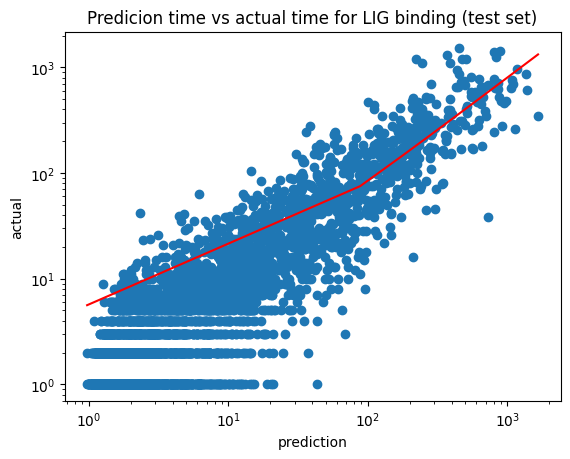

In [23]:
plt.scatter(ap2,al2)
plt.xscale("log")
plt.yscale("log")
r=np.corrcoef(ap2[:,0], al2[:,0])
print("r2:",r[0,1])

line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(min(ap2[:,0]), max(ap2[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.xlabel('prediction')
plt.show()

In [24]:
# plt.scatter(al2,ap2)
# plt.xscale("log")
# plt.yscale("log")

# plt.title("Predicion time vs actual time for LIG binding")
# plt.xlabel('actual')
# plt.ylabel('prediction')
# plt.show()

In [25]:
dmat_fas = np.load("distance_matrix_full_FAS.npy")

events_all_fas = combined_residence_events(dmat_fas)

mapping_fas = np.zeros(len(events_all_fas))
avg_fas = np.zeros([len(events_all_fas), len(dmat_fas[0,:])])
print(avg_fas.shape)
print(len(events_all_fas))
print(len(mapping_fas))


count_fas = 0
for event_fas in events_all_fas:
  mapping_fas[count_fas] = len(event_fas)
  avg_fas[count_fas] = np.mean(dmat_fas[event_fas[0]:event_fas[-1]+1], axis=0)
  count_fas += 1
  
logmapping_fas = np.log(mapping_fas)
print(logmapping_fas)

inputs_fas = torch.from_numpy(avg_fas)
inputs_fas = torch.tensor(inputs_fas, dtype=torch.float32)

print(inputs_fas.shape)
print(inputs_fas)

targets_fas= torch.from_numpy(np.reshape(logmapping_fas, (logmapping_fas.shape[0],1)))
targets_fas = torch.tensor(targets_fas, dtype=torch.float32)

print(targets_fas.shape)
print(targets_fas)

dataset_fas = TensorDataset(inputs_fas, targets_fas)

test_len_fas = mapping_fas.shape[0]
print(test_len_fas)

batch_size_fas = 64

test_dataloader_fas = DataLoader(dataset_fas, batch_size_fas)

(48714, 20)
48714
48714
[4.14313473 2.19722458 0.69314718 ... 3.8918203  2.56494936 1.09861229]
torch.Size([48714, 20])
tensor([[1.1333, 1.0077, 0.7954,  ..., 1.7707, 1.6474, 1.6849],
        [1.1891, 1.3402, 1.0463,  ..., 1.6906, 2.0585, 2.1733],
        [1.2047, 1.1775, 1.4093,  ..., 1.2054, 1.6158, 1.8064],
        ...,
        [1.1888, 1.3995, 1.5285,  ..., 1.3259, 1.5209, 1.6709],
        [1.3224, 1.0946, 0.8536,  ..., 1.6131, 1.6765, 1.9982],
        [0.7705, 0.4270, 0.3906,  ..., 2.2815, 2.2086, 2.6610]])
torch.Size([48714, 1])
tensor([[4.1431],
        [2.1972],
        [0.6931],
        ...,
        [3.8918],
        [2.5649],
        [1.0986]])
48714


/var/folders/d8/ljs_0tq104s4vglq15j0zhnr0000gn/T/ipykernel_18939/3694516274.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_fas = torch.tensor(inputs_fas, dtype=torch.float32)
/var/folders/d8/ljs_0tq104s4vglq15j0zhnr0000gn/T/ipykernel_18939/3694516274.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_fas = torch.tensor(targets_fas, dtype=torch.float32)


[1879 1326 1172 1086 1004  979  969  956  936  903  899  844  831  831
  813  810  804  802  799  783]


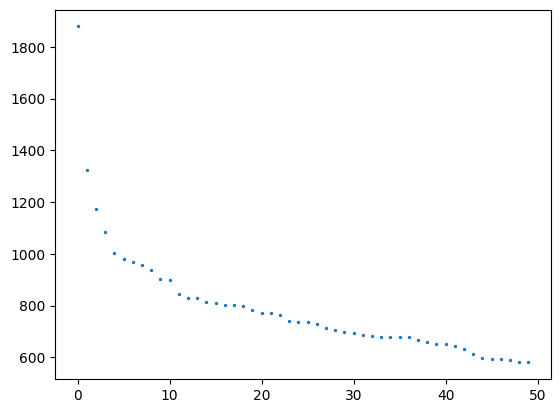

In [26]:
plotevents = np.sort(np.array([len(i) for i in events_all_fas]))[::-1]
ploteventsintime = np.array([len(i) for i in events_all_fas])

plt.scatter(np.arange(50), plotevents[:50], s = 2)
print(plotevents[:20])

In [27]:
def test_model_fas(model):
    model.eval()
    dataloader = test_dataloader_fas
    dataset_size = test_len_fas
    running_loss = 0.0
            
    all_labels= []
    all_preds= []
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        logits = model(inputs)
        loss = F.mse_loss(logits, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        all_preds.append(logits)
        all_labels.append(labels)


    epoch_loss = running_loss / dataset_size
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    print(f'Test Loss: {epoch_loss:.4f}')
    
    return all_preds, all_labels


In [28]:
ap3, al3 = test_model_fas(trained_model)

Test Loss: 0.5277


In [29]:
print(torch.mean(ap3))
print(torch.mean(al3))

ap3 = torch.exp(ap3)
al3 = torch.exp(al3)

print(torch.mean(ap3))
print(torch.mean(al3))

al3 = torch.Tensor.numpy(al3, force=True)
ap3 = torch.Tensor.numpy(ap3, force=True)

tensor(1.5192, grad_fn=<MeanBackward0>)
tensor(1.3790)
tensor(18.4198, grad_fn=<MeanBackward0>)
tensor(16.9462)


In [30]:
top = (-ap3).argsort(axis=0)[:20]
for index in top:
  print("predicted", ap3[index], "real:", al3[index])

predicted [[1651.443]] real: [[668.]]
predicted [[1349.233]] real: [[736.]]
predicted [[1310.4768]] real: [[494.00006]]
predicted [[1270.2473]] real: [[783.]]
predicted [[1215.2157]] real: [[650.0001]]
predicted [[1123.4525]] real: [[313.00006]]
predicted [[1118.3461]] real: [[201.99997]]
predicted [[1061.0024]] real: [[1085.9998]]
predicted [[1028.532]] real: [[599.0001]]
predicted [[976.99023]] real: [[581.99994]]
predicted [[937.8068]] real: [[315.99994]]
predicted [[928.3602]] real: [[386.99994]]
predicted [[904.77545]] real: [[284.00006]]
predicted [[903.7273]] real: [[352.00003]]
predicted [[894.853]] real: [[773.]]
predicted [[893.60236]] real: [[414.99994]]
predicted [[890.231]] real: [[106.000015]]
predicted [[867.6472]] real: [[406.0001]]
predicted [[861.72107]] real: [[903.0001]]
predicted [[854.1614]] real: [[676.9999]]


In [31]:
bottom = (ap3).argsort(axis=0)[:20]
for index in bottom:
  print("predicted", ap3[index], "real:", al3[index])

predicted [[0.91816914]] real: [[3.]]
predicted [[0.94507915]] real: [[1.]]
predicted [[0.946724]] real: [[1.]]
predicted [[0.9502768]] real: [[1.]]
predicted [[0.9505882]] real: [[1.]]
predicted [[0.9514773]] real: [[1.]]
predicted [[0.95493746]] real: [[1.]]
predicted [[0.95859057]] real: [[1.]]
predicted [[0.9598438]] real: [[1.]]
predicted [[0.95986044]] real: [[1.]]
predicted [[0.9642188]] real: [[2.]]
predicted [[0.9661475]] real: [[1.]]
predicted [[0.96920717]] real: [[1.]]
predicted [[0.9734863]] real: [[1.]]
predicted [[0.9735035]] real: [[1.]]
predicted [[0.9740601]] real: [[1.]]
predicted [[0.9751386]] real: [[1.]]
predicted [[0.976862]] real: [[1.]]
predicted [[0.9777376]] real: [[1.]]
predicted [[0.97902346]] real: [[1.]]


r2: 0.7973429855589935
Line Parameters: [0.69756732 4.09711425]


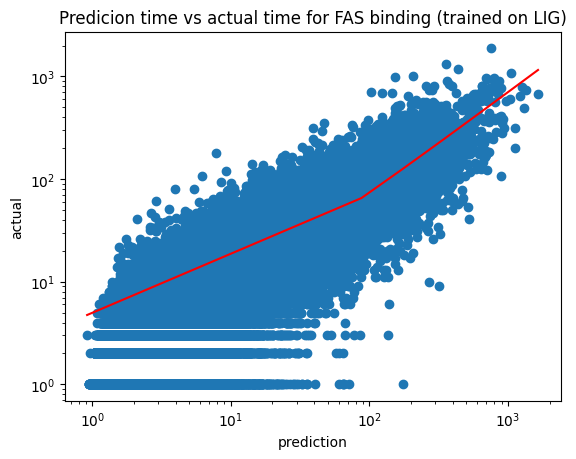

In [32]:
plt.scatter(ap3,al3)
plt.xscale("log")
plt.yscale("log")
r=np.corrcoef(ap3[:,0], al3[:,0])
print("r2:",r[0,1])

line_fit=np.polyfit(ap3[:,0], al3[:,0], 1)
x = np.linspace(min(ap3[:,0]), max(ap3[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.title("Predicion time vs actual time for FAS binding (trained on LIG)")
plt.ylabel('actual')
plt.xlabel('prediction')
plt.show()